# DATAVIZ Exam
<b>Nicolò Romandini</b></br>
Matricola: 0001023921</br>
PhD Course: Data Visualization for Scientists

# Dataset Preprocessing
The dataset used refers to the [2012 PhysioNet Challenge](https://physionet.org/content/challenge-2012/1.0.0/). The task was to predict the death of patients admitted to the ICU. Each file refers to a different patient and in it are measurements for various parameters over the ICU stay. 

In [2]:
import pandas as pd
import numpy as np
import os

# Load outcome datasets

outcomes_a = pd.read_csv('./Outcomes-a.txt')
outcomes_b = pd.read_csv('./Outcomes-b.txt')
outcomes_c = pd.read_csv('./Outcomes-c.txt')
outcomes = pd.concat([outcomes_a, outcomes_b, outcomes_c])

patients = list()

# Extract variables datasets

import zipfile
with zipfile.ZipFile("./sets.zip", 'r') as zip_ref:
    zip_ref.extractall(".")

# Load variables datasets

for f in os.listdir('set-a'):
    with open(os.path.join('set-a', f), 'r') as fp:
        txt = fp.readlines()

    txt = [t.rstrip('\n').split(',') for t in txt]
    
    patients.extend([txt[1:]])
for f in os.listdir('set-b'):
    with open(os.path.join('set-b', f), 'r') as fp:
        txt = fp.readlines()
        
    txt = [t.rstrip('\n').split(',') for t in txt]
    
    patients.extend([txt[1:]])
for f in os.listdir('set-c'):
    with open(os.path.join('set-c', f), 'r') as fp:
        txt = fp.readlines()
        
    txt = [t.rstrip('\n').split(',') for t in txt]
    
    patients.extend([txt[1:]])

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set colorblind palette and Arial font
sns.set_palette('colorblind')
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['patch.force_edgecolor'] = True
colorblind_palette = sns.color_palette()



In [4]:
# Save data in variables to plot them

ages_death = {}
ages_d = []
ages_s = []
ages = {}
icu_type = {}
icu_death = {}
num_patients = 0
dead = 0
df = []
for p in patients:
    num_patients += 1
    age = None
    record_id = None
    icu = None
    added = False
    gender = None
    for measurment in p:
        hour, name, value = measurment
        h = int(hour.split(':')[0])
        m = int(hour.split(':')[1])/60
        h = h + m

        # Skip the time-series variables
        if h >= 2:
            continue
        
        if name == 'RecordID':
            record_id = value
        if name == 'Age':
            age = int(value)
        if name == 'ICUType':
            icu = int(value)
        if name == 'Gender':
            if value == "1":
                gender = "Male"
            elif value == "0":
                gender = "Female"

        if record_id is not None and age is not None and icu is not None and not added and gender is not None:
            added = True
            outcome = int(outcomes.loc[outcomes['RecordID'] == int(record_id)]['In-hospital_death'].values[0])
            dead += outcome
            if outcome:
                ages_d.append(age)
                df.append([age, gender, "Deceased"])
            else:
                ages_s.append(age)
                df.append([age, gender, "Survived"])

            if age in ages_death:
                ages_death[age] += outcome
                ages[age] += 1
            else:
                ages_death[age] = outcome
                ages[age] = 1
            if icu in icu_type:
                icu_type[icu] += 1
                icu_death[icu] += outcome
            else:
                icu_type[icu] = 1
                icu_death[icu] = outcome

            

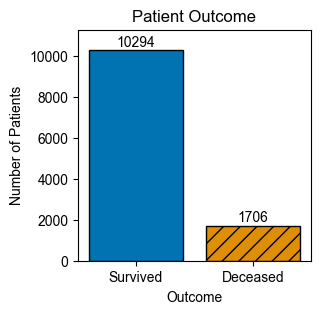

In [26]:
plt.figure(figsize=(3, 3))

barlist = plt.bar("Survived",num_patients-dead)

plt.title("Patient Outcome")
plt.bar("Deceased", dead, hatch="//")
plt.text(0, (num_patients-dead) + 200 , num_patients-dead, ha = 'center')
plt.text(1, dead + 200, dead, ha = 'center')
# Add the specific number for clarity 
plt.ylim(top = (num_patients-dead) + 1000)

plt.xlabel("Outcome")
plt.ylabel("Number of Patients")
plt.show()

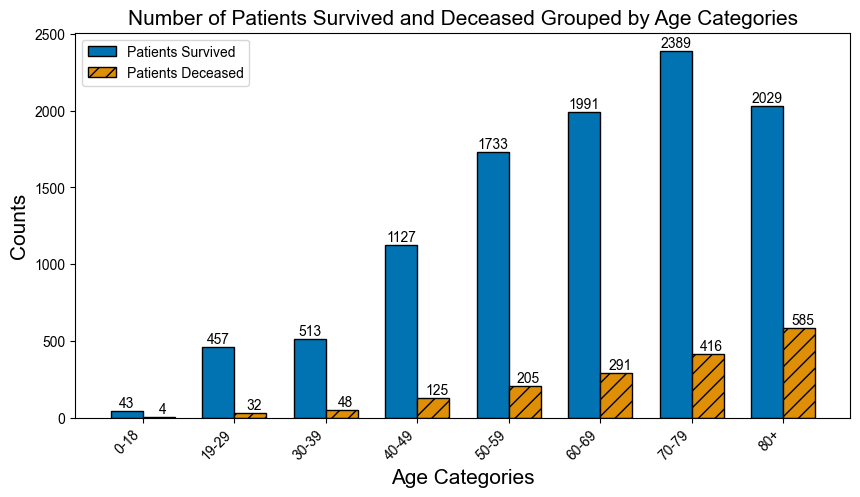

In [45]:
# Define age categories
age_categories = {
    '0-18': [],
    '19-29': [],
    '30-39': [],
    '40-49': [],
    '50-59': [],
    '60-69': [],
    '70-79': [],
    '80+': [],
}

for age, count in ages.items():
    value = (count - ages_death.get(age, 0), ages_death.get(age, 0))
    if age <= 18:
        age_categories['0-18'].append(value)
    elif 19 <= age <= 29:
        age_categories['19-29'].append(value)
    elif 30 <= age <= 39:
        age_categories['30-39'].append(value)
    elif 40 <= age <= 49:
        age_categories['40-49'].append(value)
    elif 50 <= age <= 59:
        age_categories['50-59'].append(value)
    elif 60 <= age <= 69:
        age_categories['60-69'].append(value)
    elif 70 <= age <= 79:
        age_categories['70-79'].append(value)
    else:
        age_categories['80+'].append(value)

# Calculate the sum of counts and deaths for each age category
category_counts = {category: [count for count, _ in counts] for category, counts in age_categories.items()}
category_deaths = {category: [deaths for _, deaths in counts] for category, counts in age_categories.items()}

age_categories_list = list(age_categories.keys())
width = 0.35
x = np.arange(len(age_categories_list))

fig, ax = plt.subplots(figsize=(10, 5))

bar1 = ax.bar(x - width/2, [sum(count) for count in category_counts.values()], width, label='Patients Survived')
bar2 = ax.bar(x + width/2, [sum(deaths) for deaths in category_deaths.values()], width, label='Patients Deceased', hatch='//')

# Add count labels on top of the bars
for i, count in enumerate([sum(count) for count in category_counts.values()]):
    plt.text(x[i] - width/2, count + 5, str(count), ha='center', va='bottom', fontsize=10)

for i, death_count in enumerate([sum(deaths) for deaths in category_deaths.values()]):
    plt.text(x[i] + width/2 +0.04 , death_count + 5, str(death_count), ha='center', va='bottom', fontsize=10)


# Rotate x-axis labels for readability
plt.xticks(x, age_categories_list, rotation=45, ha='right')

plt.xlabel('Age Categories', fontsize=15)
plt.ylabel('Counts', fontsize=15)
plt.title('Number of Patients Survived and Deceased Grouped by Age Categories', fontsize=15)
plt.legend()

plt.show()

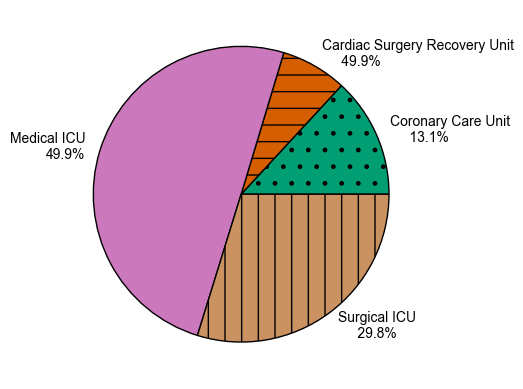

In [32]:
icu_type = dict(sorted(icu_type.items()))
icu_death = dict(sorted(icu_death.items()))

i_d = sum(icu_death.values())
percentage = [x/i_d * 100 for x in icu_death.values()]
plt.pie(percentage, labels = ["Coronary Care Unit\n     "+str(round(percentage[0],1))+"%", "Cardiac Surgery Recovery Unit\n     "+str(round(percentage[2],1))+"%",
"Medical ICU\n"+str(round(percentage[2],1))+"%","Surgical ICU\n     "+str(round(percentage[3],1))+"%"], hatch = [".", "-", "", "|"], colors=colorblind_palette[2:6])
plt.show()

c:\Users\Nicolo\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Nicolo\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Nicolo\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Nicolo\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is 

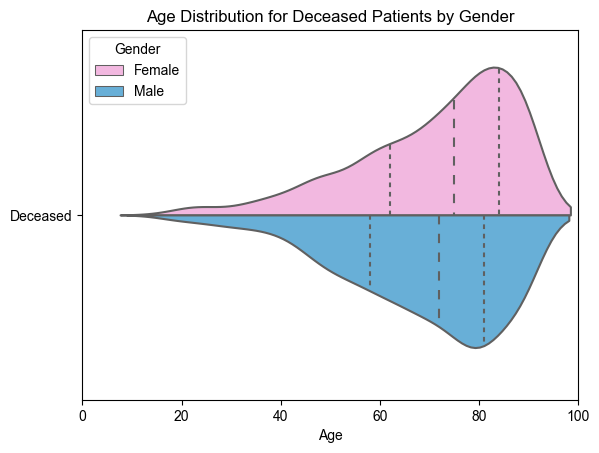

In [25]:
df = pd.DataFrame(df, columns=["Age", "Gender", "Outcome"])

deceased_df = df[df['Outcome'] == 'Deceased']

ax = sns.violinplot(data=deceased_df, x="Age", y="Outcome", hue="Gender", split=True, inner='quart', palette=[colorblind_palette[6], colorblind_palette[9]])
ax.set_title("Age Distribution for Deceased Patients by Gender")
ax.set_xlim(0, 100)
ax.set_ylabel("")

plt.show()
